In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

ValueError: ignored

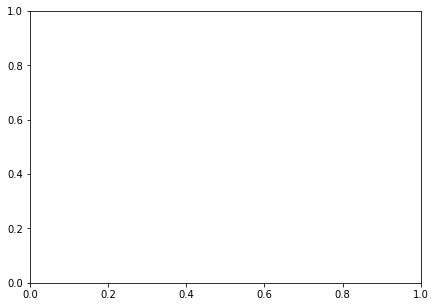

In [ ]:
##### Find optimal number of principal components #####

res = pd.read_csv("yields.csv")
res = res["Yield"]

pred = pd.read_csv("combined_indices.csv")
pred = pred.iloc[:,1:]
components = list(range(1,13))
pca_all = PCA(n_components=0.999)
pca_all.fit(pred)
explained_variance = np.cumsum(pca_all.explained_variance_ratio_)

fig, ax = plt.subplots(figsize=(7,5))
plt.plot(components, explained_variance, '-bo')
plt.xlabel('No. of Principal Components', fontsize=15, labelpad=15)
plt.ylabel('Cumulative Variance', fontsize=15, labelpad=15)
plt.title('Explained Variance Ratio', fontsize=15, pad=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.show()
#plt.savefig("explained_variance.png")

In [ ]:
def prepare_data():
   # Import response variable
   res = pd.read_csv("yield.csv")
   res = res["Yield"]

   # Import predictors
   pred = pd.read_csv("combined_indices.csv")
   pred = pred.iloc[:,1:]

   # Concatenate response and predictor dataframes
   data = pd.concat([pred,res], axis=1)

   # Separate predictors and response again
   X = data.iloc[:,:-1]
   Y = data.iloc[:,-1]

   # Choose 80% of data randomly for training and rest for testing
   X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

   return(X_train, X_test, Y_train, Y_test)

def metrics(y_pred, y_test):
    r2 = r2_score(y_pred, y_test.to_list())
    rmse = sqrt(mean_squared_error(y_pred, y_test.to_list()))
    return r2, rmse

In [ ]:
##### Linear Methods ######

In [ ]:
#### Principal Component Regression #####

X_train, X_test, Y_train, Y_test = prepare_data()
pca = PCA(n_components=0.95)
pca_train = pd.DataFrame(pca.fit_transform(X_train))
pca_test = pd.DataFrame(pca.transform(X_test))

linear = LinearRegression(fit_intercept=True, normalize=False, copy_X=True)
linear.fit(pca_train, Y_train)
y_pred = linear.predict(pca_test)

r2, rmse = metrics(y_pred, Y_test)
print r2, rmse

0.899920257713598 0.327769140332


In [ ]:
#### Ridge Regression ####
alpha_arr = np.arange(0.1,10,0.5)

def ridge(alpha, x_train, y_train, x_test):
    model = Ridge(alpha = alpha)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return y_pred

X_train, X_test, Y_train, Y_test = prepare_data()

#### Perform k-fold CV. kf_split only produces indices of rows #####
kf = KFold(n_splits=5)
r2_arr = []
rmse_arr = []
results = pd.DataFrame([],columns=["Alpha","R^2","RMSE"],index=np.arange(0, len(alpha_arr)))

for i in range(0,len(alpha_arr)): 
 for train_indices, test_indices in kf.split(X_train):
    x_train = X_train.iloc[train_indices,:].reset_index(drop=True)
    y_train = Y_train.iloc[train_indices].reset_index(drop=True)
    x_test = X_train.iloc[test_indices,:].reset_index(drop=True)
    y_test = Y_train.iloc[test_indices].reset_index(drop=True)
    
    # Ridge
    alpha = alpha_arr[i] 
    y_pred = ridge(alpha, x_train, y_train, x_test)
 
    # Calculate R^2 and rmse
    r2, rmse = metrics(y_pred, y_test)
    r2_arr.append(r2)
    rmse_arr.append(rmse)
    
 results["Alpha"][i] = alpha
 results["R^2"][i] = np.mean(r2_arr)
 results["RMSE"][i] = np.mean(rmse_arr)

#### Based on the results, choose alpha = 5
#### Get final results
alpha=5
y_pred = ridge(alpha, X_train, Y_train, X_test)
r2, rmse = metrics(y_pred, Y_test)
print r2, rmse

0.882382861849851 0.331021067958


In [ ]:
##### Non Linear Methods #####

In [ ]:
##### Support Vector Regression #####
X_train, X_test, Y_train, Y_test = prepare_data()
tuned_parameters = [{'kernel':['linear','rbf'], 'C':[0.1, 0.2, 0.3, 0.5, 1, 2, 5, 10], 
                     'epsilon':[0.01, 0.05, 0.1, 0.2, 0.5]}]
grid = GridSearchCV(SVR(), tuned_parameters, cv=5)
grid.fit(X_train, Y_train.values.ravel())
best_params = grid.best_params_

## Get final results
model = SVR(kernel=best_params["kernel"], C=best_params["C"], epsilon=best_params["epsilon"])
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
r2, rmse = metrics(Y_pred, Y_test)
print best_params
print r2, rmse

{'epsilon': 0.2, 'C': 0.1, 'kernel': 'linear'}
0.8891888035312312 0.330659177012


In [ ]:
##### Random Forest Regression #####
X_train, X_test, Y_train, Y_test = prepare_data()
tuned_parameters = [{'n_estimators':[10,20,50,100,250,500], 'max_features':["auto","sqrt","log2"], 
                    'min_samples_split':[2,4,6], 'random_state':[100]}]
grid = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5)
grid.fit(X_train, Y_train.values.ravel())
best_params = grid.best_params_
print best_params
model = RandomForestRegressor(n_estimators=best_params["n_estimators"], max_features=best_params["max_features"],
                             min_samples_split=best_params["min_samples_split"], random_state=5)
model.fit(X_train, Y_train.values.ravel())
y_pred = model.predict(X_test)
r2, rmse = metrics(y_pred, Y_test)
print r2, rmse

{'max_features': 'auto', 'min_samples_split': 2, 'random_state': 100, 'n_estimators': 20}
0.9303951830599273 0.257441691032
[0.92878654 0.00942086 0.0084738  0.00354312 0.00418719 0.00602454
 0.00607116 0.01286564 0.00171019 0.01031302 0.00416758 0.00443638]
